In [36]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import accuracy_score

import sys
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model

In [41]:
#Parameters to change, can change model_type to 'best' or 'last'
use_jet_pt = True
use_jet_mass = True
N = 6
model_type = 'best'
extra_name = ''

#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'
#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass)
testloader = DataLoader(test_set, shuffle=False, batch_size=256, num_workers=30, pin_memory=True, persistent_workers=True)

#model path
model_path = '../../models/Multi-Body/models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass)

#loading model
model = Model(N, use_jet_pt, use_jet_mass).cuda().double()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (dense1): Linear(in_features=16, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [43]:
def evaluate_model(model, test_loader):
   
    #Find loss and accuracy
    crit = torch.nn.BCELoss()
    val_loss_total=0
    test_top1_total=0
    acc=0
    _, labels=test_set[:]
    total_preds = []
    with torch.no_grad():
        for x,y in tqdm(test_loader):
            x = x.cuda()
            y = y.cuda()
            pred = model(x)
            loss = crit(pred, y)
            val_loss_total += loss.item()
            #accuracy is determined by rounding. Any number <= 0.5 get's rounded down to 0
            #The rest get rounded up to 1
            top1 = accuracy_score(pred[:,1].round().cpu(), y[:,1].cpu(), normalize=False)
            test_top1_total += top1.item()
            total_preds.append(pred.cpu().numpy())
    total_preds = np.concatenate(total_preds, axis=0)
    print("Loss: "+str(val_loss_total/len(testloader)))    
    print("Accuracy: "+str(test_top1_total/len(test_set)))
    return total_preds

def evaluate_model_mean(model, test_loader):
   
    #Find loss and accuracy
    crit = torch.nn.BCELoss()
    val_loss_total=0
    test_top1_total=0
    acc=0
    _, labels=test_set[:]
    total_preds = []
    with torch.no_grad():
        for x,y in tqdm(test_loader):
            x = x.cuda()
            #15 is N=6 pt, 21 is N=8 pt
            x[:,15] = torch.full_like(x[:,15], torch.mean(x[:,15]))
            y = y.cuda()
            pred = model(x)
            loss = crit(pred, y)
            val_loss_total += loss.item()
            #accuracy is determined by rounding. Any number <= 0.5 get's rounded down to 0
            #The rest get rounded up to 1
            top1 = accuracy_score(pred[:,1].round().cpu(), y[:,1].cpu(), normalize=False)
            test_top1_total += top1.item()
            total_preds.append(pred.cpu().numpy())
    total_preds = np.concatenate(total_preds, axis=0)
    print("Loss: "+str(val_loss_total/len(testloader)))    
    print("Accuracy: "+str(test_top1_total/len(test_set)))
    return total_preds

print("Performance on test set")
total_preds = evaluate_model(model,testloader)

print("Performance on test set with pt batch mean")
total_preds_batch_mean = evaluate_model_mean(model,testloader)


Performance on test set


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:04<00:00, 329.47it/s]


Loss: 0.1802195618589196
Accuracy: 0.9265537005731662
Performance on test set with pt batch mean


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:06<00:00, 254.13it/s]

Loss: 0.3003381985455121
Accuracy: 0.8718328315211411


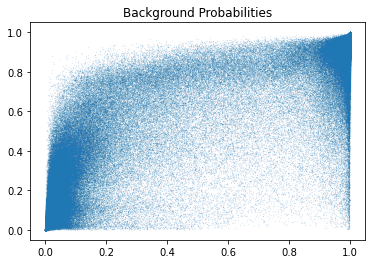

In [44]:
plt.scatter(total_preds[:,0], total_preds_batch_mean[:,0], marker='.', s=0.01)
plt.title('Background Probabilities')
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/pt_batch_mean_bkg_scatter.png", dpi = 150, bbox_inches='tight')
plt.show()

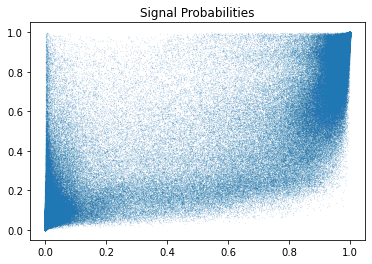

In [45]:
plt.scatter(total_preds[:,1], total_preds_batch_mean[:,1], marker='.', s=0.01)
plt.title('Signal Probabilities')
#plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/pt_batch_mean_sig_scatter.png", dpi = 150, bbox_inches='tight')
plt.show()